In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.grid_search import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from pandas_confusion import ConfusionMatrix

%matplotlib inline

In [2]:
def HourOfDay(df):
    ft = df.map(lambda x: x.hour)
    feat = pd.cut(ft, bins = [0,3,6,9,12,15,18,21,24], right=False)
    feat.name = 'HourOfDay'
    return feat

def Month(df):
    feat = df.map(lambda x: x.strftime("%B"))
    feat.name = 'Month'
    return feat

def Week(df):
    feat = df.apply(lambda x: 'W'+str(x.isocalendar()[1]))
    feat.name = 'Week'
    return feat

def ZipCode(df): 
    feat = df.apply(lambda x: 'Z'+str(x))
    feat.name = 'ZipCode'
    return feat

def IsIntersection(df):
    feat = df.apply(lambda x: 0 if x.find("/") < 0 else 1)
    feat.name = 'IsIntersection'
    return feat

def Lng(df):
    minX, maxX = df.min(), df.max()
    feat = df.apply(lambda x: (x-minX)/(maxX-minX))
    feat.name = 'Lng'
    return feat

def Lat(df):
    minY, maxY = df.min(), df.max()
    feat = df.apply(lambda x: (x-minY)/(maxY-minY))
    feat.name = 'Lat'
    return feat

def build_dataset(data, n=14):
    data['Dates'] = pd.to_datetime(data['Dates'])
    if 'Category' in data.columns:
        topcats = data['Category'].value_counts().index.tolist()[n:]
        data['Target'] = data['Category']
        data.loc[data['Target'].isin(topcats), 'Target'] = 'OTHER CRIMES'

    features = pd.DataFrame(index=data.index)
    features = features.join(data['DayOfWeek'])
    features = features.join(HourOfDay(data['Dates']))
    features = features.join(Month(data['Dates']))
    features = features.join(data['PdDistrict'])
    features = features.join(ZipCode(data['ZipCode']))
    features = features.join(Lat(data['Y']))
    features = features.join(Lng(data['X']))
    features = features.join(IsIntersection(data['Address']))
    features = features.join(Week(data['Dates']))
        
    return features, data['Target'] if 'Target' in data.columns else None

In [3]:
train_data = pd.read_csv('data/train-A.csv', quotechar='"')
test_data  = pd.read_csv('data/train-B.csv', quotechar='"')

In [4]:
train_features,y_train  = build_dataset(train_data)
test_features,y_test    = build_dataset(test_data)

In [5]:
y_train.value_counts()/sum(y_train.value_counts())

LARCENY/THEFT             0.199250
OTHER OFFENSES            0.143645
NON-CRIMINAL              0.105421
ASSAULT                   0.087235
OTHER CRIMES              0.078167
DRUG/NARCOTIC             0.061395
VEHICLE THEFT             0.061260
VANDALISM                 0.050976
WARRANTS                  0.048187
BURGLARY                  0.041719
SUSPICIOUS OCC            0.035689
MISSING PERSON            0.029731
ROBBERY                   0.026314
FRAUD                     0.018965
FORGERY/COUNTERFEITING    0.012047
Name: Target, dtype: float64

In [6]:
train_features.head(5)

,DayOfWeek,HourOfDay,Month,PdDistrict,ZipCode,Lat,Lng,IsIntersection,Week
0,Wednesday,"[21, 24)",May,NORTHERN,Z94102,0.001276,0.043578,1,W20
1,Wednesday,"[21, 24)",May,NORTHERN,Z94102,0.001276,0.043578,1,W20
2,Wednesday,"[21, 24)",May,NORTHERN,Z94123,0.001778,0.043030,0,W20
3,Wednesday,"[21, 24)",May,PARK,Z94117,0.001217,0.037198,0,W20
4,Wednesday,"[21, 24)",May,INGLESIDE,Z94134,0.000330,0.044852,1,W20


In [7]:
train_features.shape

(613862, 9)

In [8]:
d_train = train_features.T.to_dict().values()
d_test = test_features.T.to_dict().values()

vectorizer = DictVectorizer(sparse=True)

X_train = vectorizer.fit_transform(d_train)
X_test  = vectorizer.transform(d_test)

X_train.shape

(613862, 93)

In [9]:
vectorizer.get_feature_names()

['DayOfWeek=Friday',
 'DayOfWeek=Monday',
 'DayOfWeek=Saturday',
 'DayOfWeek=Sunday',
 'DayOfWeek=Thursday',
 'DayOfWeek=Tuesday',
 'DayOfWeek=Wednesday',
 'HourOfDay=[0, 3)',
 'HourOfDay=[12, 15)',
 'HourOfDay=[15, 18)',
 'HourOfDay=[18, 21)',
 'HourOfDay=[21, 24)',
 'HourOfDay=[3, 6)',
 'HourOfDay=[6, 9)',
 'HourOfDay=[9, 12)',
 'IsIntersection',
 'Lat',
 'Lng',
 'Month=April',
 'Month=August',
 'Month=December',
 'Month=February',
 'Month=January',
 'Month=July',
 'Month=June',
 'Month=March',
 'Month=May',
 'Month=November',
 'Month=October',
 'Month=September',
 'PdDistrict=BAYVIEW',
 'PdDistrict=CENTRAL',
 'PdDistrict=INGLESIDE',
 'PdDistrict=MISSION',
 'PdDistrict=NORTHERN',
 'PdDistrict=PARK',
 'PdDistrict=RICHMOND',
 'PdDistrict=SOUTHERN',
 'PdDistrict=TARAVAL',
 'PdDistrict=TENDERLOIN',
 'Week=W10',
 'Week=W12',
 'Week=W14',
 'Week=W16',
 'Week=W18',
 'Week=W2',
 'Week=W20',
 'Week=W22',
 'Week=W24',
 'Week=W26',
 'Week=W28',
 'Week=W30',
 'Week=W32',
 'Week=W34',
 'Week=W36'

In [10]:
rparams = dict(C=[1.0e-3, 1.0e-2, 1.0e-1, 1.0e0, 1.0e1, 1.0e2])

lr = LogisticRegression(penalty='l2', C=0.01, max_iter=1000,\
                         multi_class='ovr', n_jobs=-1,\
                         solver='lbfgs', class_weight='balanced', verbose=0) ## , 

clf = GridSearchCV(lr, param_grid=rparams, scoring='log_loss', n_jobs=1, verbose=2)
clf.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] C=0.001 .........................................................
[CV] ................................................ C=0.001 -  12.8s
[CV] C=0.001 .........................................................
[CV] ................................................ C=0.001 -  12.9s
[CV] C=0.001 .........................................................
[CV] ................................................ C=0.001 -  12.8s
[CV] C=0.01 ..........................................................
[CV] ................................................. C=0.01 -  23.2s
[CV] C=0.01 ..........................................................
[CV] ................................................. C=0.01 -  23.8s
[CV] C=0.01 ..........................................................
[CV] ................................................. C=0.01 -  22.2s
[CV] C=0.1 ...........................................................
[CV] ............

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 20.4min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=0.01, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=1000,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring='log_loss', verbose=2)

In [11]:
print(clf.best_params_)

{'C': 0.1}


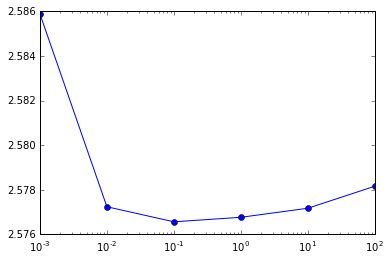

In [12]:
cv_scores = np.zeros(6)
c = np.zeros(6)

rownum = 0
for params, mean_score, scores in clf.grid_scores_:
    c[rownum] = params['C']
    cv_scores[rownum] = -1.0*mean_score
    rownum = rownum + 1

plt.plot(c, cv_scores, '-o')
plt.xscale('log')

In [13]:
predicted = clf.predict(X_test)
expected = y_test
print(accuracy_score(expected, predicted))

0.160314474217


In [14]:
predicted_probs = clf.predict_proba(X_test)
print(log_loss(y_test, predicted_probs))

2.5696923314


In [15]:
cm = ConfusionMatrix(expected, predicted)
cm_stats = cm.to_dataframe().apply(lambda x: x/sum(x), axis=1)
cm_stats.to_csv('data/confusion_matrix_stats.csv')

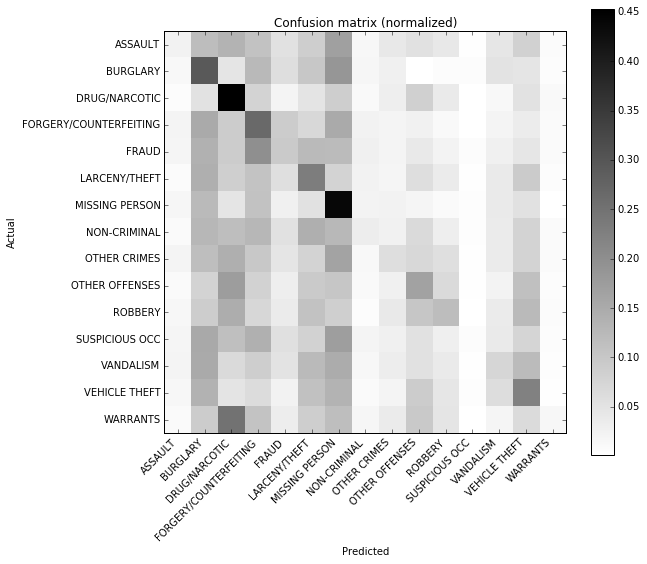

In [16]:
mpl.rcParams['figure.figsize'] = (10.0, 5.0)
cm.plot(normalized=True)